### Outline for CNNs notebook

1. Recall general architecture of MLPs
2. High-level overview of CNN architecture
    - Input layer
    - Convolutional layer
    - Pooling layer
    - Fully connected layer
3. Convolutions
    - What kind of data do we use convolutions on? (images, time series, ordered data in general)
    - What is a convolution good for?
        - Finite differences to approximate derivatives in time series
        - Moving average to smooth out noise
        - Convolution with dirac delta to extract a part of a signal
        - Convolution of probability distributions
        - Edge detection in images
        - Feature extraction in general by convolution with a filter/kernel
4. Convolutional layer
    - Convolution operation
    - Stride
    - Padding
    - Number of filters
    - Activation function
5. Pooling layer
    - Max pooling
    - Average pooling
    - Global average pooling
6. Fully connected layer
7. CNNs in practice
    - Example of a CNN architecture
    - Example of a CNN training
    - Example of a CNN application

# 1. Recall general architecture of MLPs

In the previous lecture, we explored the XOR problem and discovered why simple perceptrons are insufficient for solving it, necessitating the use of multilayer perceptrons (MLPs). Let's recall the general architecture of an MLP.

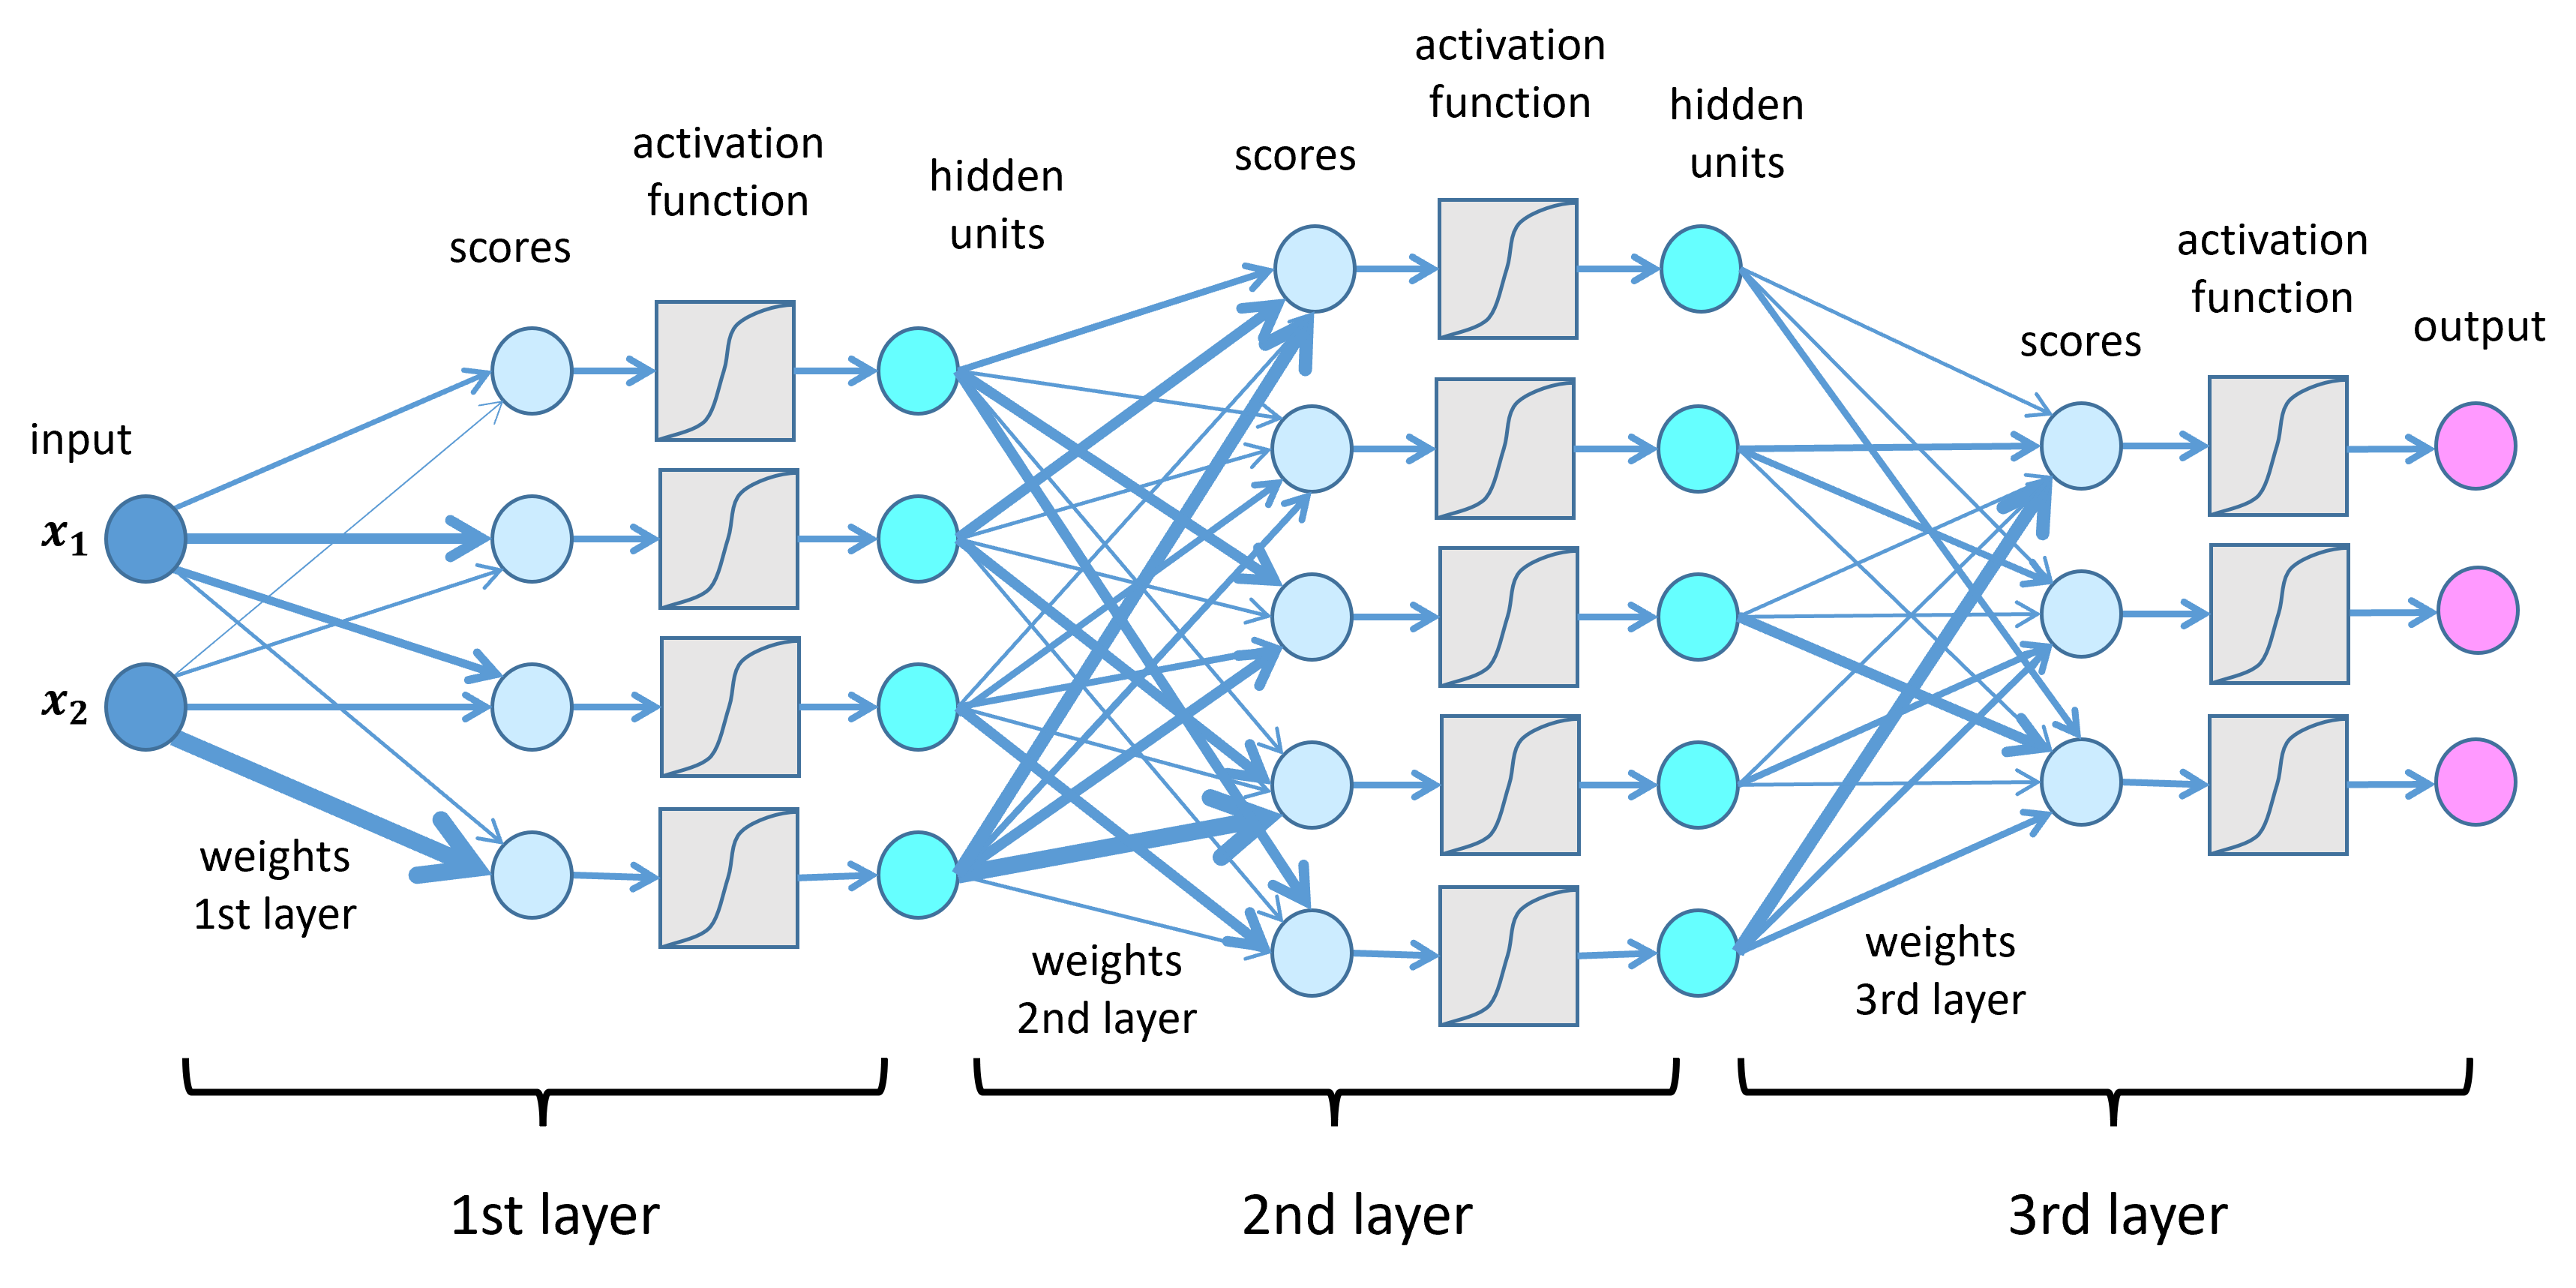

In [19]:
from IPython.display import Image, display

display(Image('Neural networks - Lamarr Institute.png'))

The diagram above shows a Multilayer Perceptron with:
- Input layer: 2 neurons ($x_1$, $x_2$)
- Hidden layer 1: 4 neurons
- Hidden layer 2: 5 neurons
- Output layer: 3 neurons

Each connection between neurons represents a weight parameter that the network learns during training. The thickness of the arrows represents the magnitude of the weights (analogous to how synapses have different strengths in biological neural networks).

The MLP processes data by passing it through these layers sequentially:
- From each layer, the data is first multiplied by the weights and aggregated to form a bunch of scores (weighted sums).
- Then, the scores are passed through an activation function (like ReLU, Sigmoid, or Tanh) to introduce non-linearity. In fact, the picture above visualizes a sigmoidal activation function, such as the logistic function $$\sigma(z) = \frac{1}{1 + e^{-z}},$$ or the hyperbolic tangent function $$\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}.$$
- The two operations above together constitute a single layer of the network. 

The final layer above is the output layer, which produces the final predictions of the network. For example, if we are using the neural network for a multi-class classification task with $3$ classes, the output layer will have $3$ neurons, each representing the probability of the input belonging to a particular class, and these probabilities would be obtained by taking the last bunch of scores and passing them through a softmax function.

### ReLU activation function
The power and flexibility of neural networks comes in large part from the non-linear activation functions. Note that $\sigma$ has range $(0, 1)$ and $\tanh$ has range $(-1, 1)$. 

A very popular activation function (of a different flavor from the previous two) is the Rectified Linear Unit (ReLU), which is defined as $$\text{ReLU}(z) = \max(0, z).$$
The ReLU function is computationally efficient and has been shown to work well in practice; it is used in many state-of-the-art neural networks.

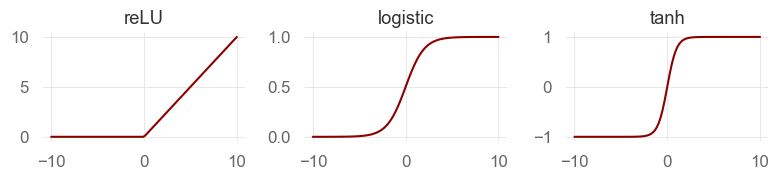

In [20]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# python let's you define functions in a very simple way:
def reLU(x):
    return np.maximum(0, x)

def logistic(x):
    return 1 / (1 + np.exp(-x))

# Define a list of functions and names
activations = [('reLU', reLU), 
               ('logistic', logistic), 
               ('tanh', np.tanh)]

# Define the input range
x = np.linspace(-10, 10, 100)

# loop over the list for plotting
fig, axes = plt.subplots(1, 3, figsize=(8, 2))
for i, (name, f) in enumerate(activations):
    axes[i].plot(x, f(x), c='darkred')
    axes[i].set_title(f'{name}')
    axes[i].grid(True)
plt.tight_layout()
plt.show()

## 2. High-level overview of CNN architecture
Suppose we are working with an image classification task. Thus, we want to feed in an image as input and obtain a class label as output. (For this, we will have a pre-defined list of class labels, such as "cat", "dog", "car", etc.)

In such a scenario, the architecture of a CNN would look something like this:
1. **Input layer**: The input to the network is an image, stored as a tensor of shape `(height, width, channels)`. 
    - For color images, we typically have `channels = 3`, for Red, Green, and Blue (RGB). 
    - Alternatively, grayscale images have `channel = 1`, which represents pixel intensity.
2. **Convolutional layer**: The convolutional layer is the core building block of a CNN. 
    - It applies a set of *filters* to the input image, each of which detects a particular "feature" (e.g. edges, texture). 
    - These filters are defined by weights, which are learned during model training. 
    - The outputs of the convolutional layer are called *feature maps*; they are tensors with the same spatial dimension, but with one channel for each filter. 
    - These feature maps are then passed through an activation function (like ReLU) to introduce non-linearity.
    - **Fact**: The act of "applying" the filter is a linear operation called convolution, and convolutional layers can in fact be understood as usual fully connected layers, but with a particular weight structure in which most weights are zero, and the non-zero weights represent the filter values.
3. **Pooling layer**: Every convolutional layer is followed by a pooling layer to reduce model complexity and guard and overfitting.
    - It reduces the spatial dimensions of the incoming feature maps, resulting in a smaller representation of the learned features. 
    - The pooling operation involves applying a simple function (like max or average) to sub-regions of the feature map. In particular, there are no weights to learn in a pooling layer.
    - The output of the pooling layer is a "downsampled" version of the input feature map, with reduced spatial dimensions but the same number of channels as the input.
- **Fully connected layer**: After several convolutional and pooling layers, the final output of the network is typically fed through a multi-layer perceptron.
    - It takes the output of the last pooling layer and flattens it into a 1D array.
    - This 1D array is then passed through an MLP in which each layer is fully connected to the next. Of course, these connections have weights that are learned during training.
    - Applying a softmax function to the output of the MLP gives the final class probabilities.

Given below is depiction of the CNN architecture (with only one convolutional layer and one pooling layer) applied to an image classification task. Note that the convolutional and pooling layers have the effect of converting the raw input image tensor into another tensor that has somehow absorbed the important features of the image. This tensor is then passed through a fully connected layer to make the final prediction.

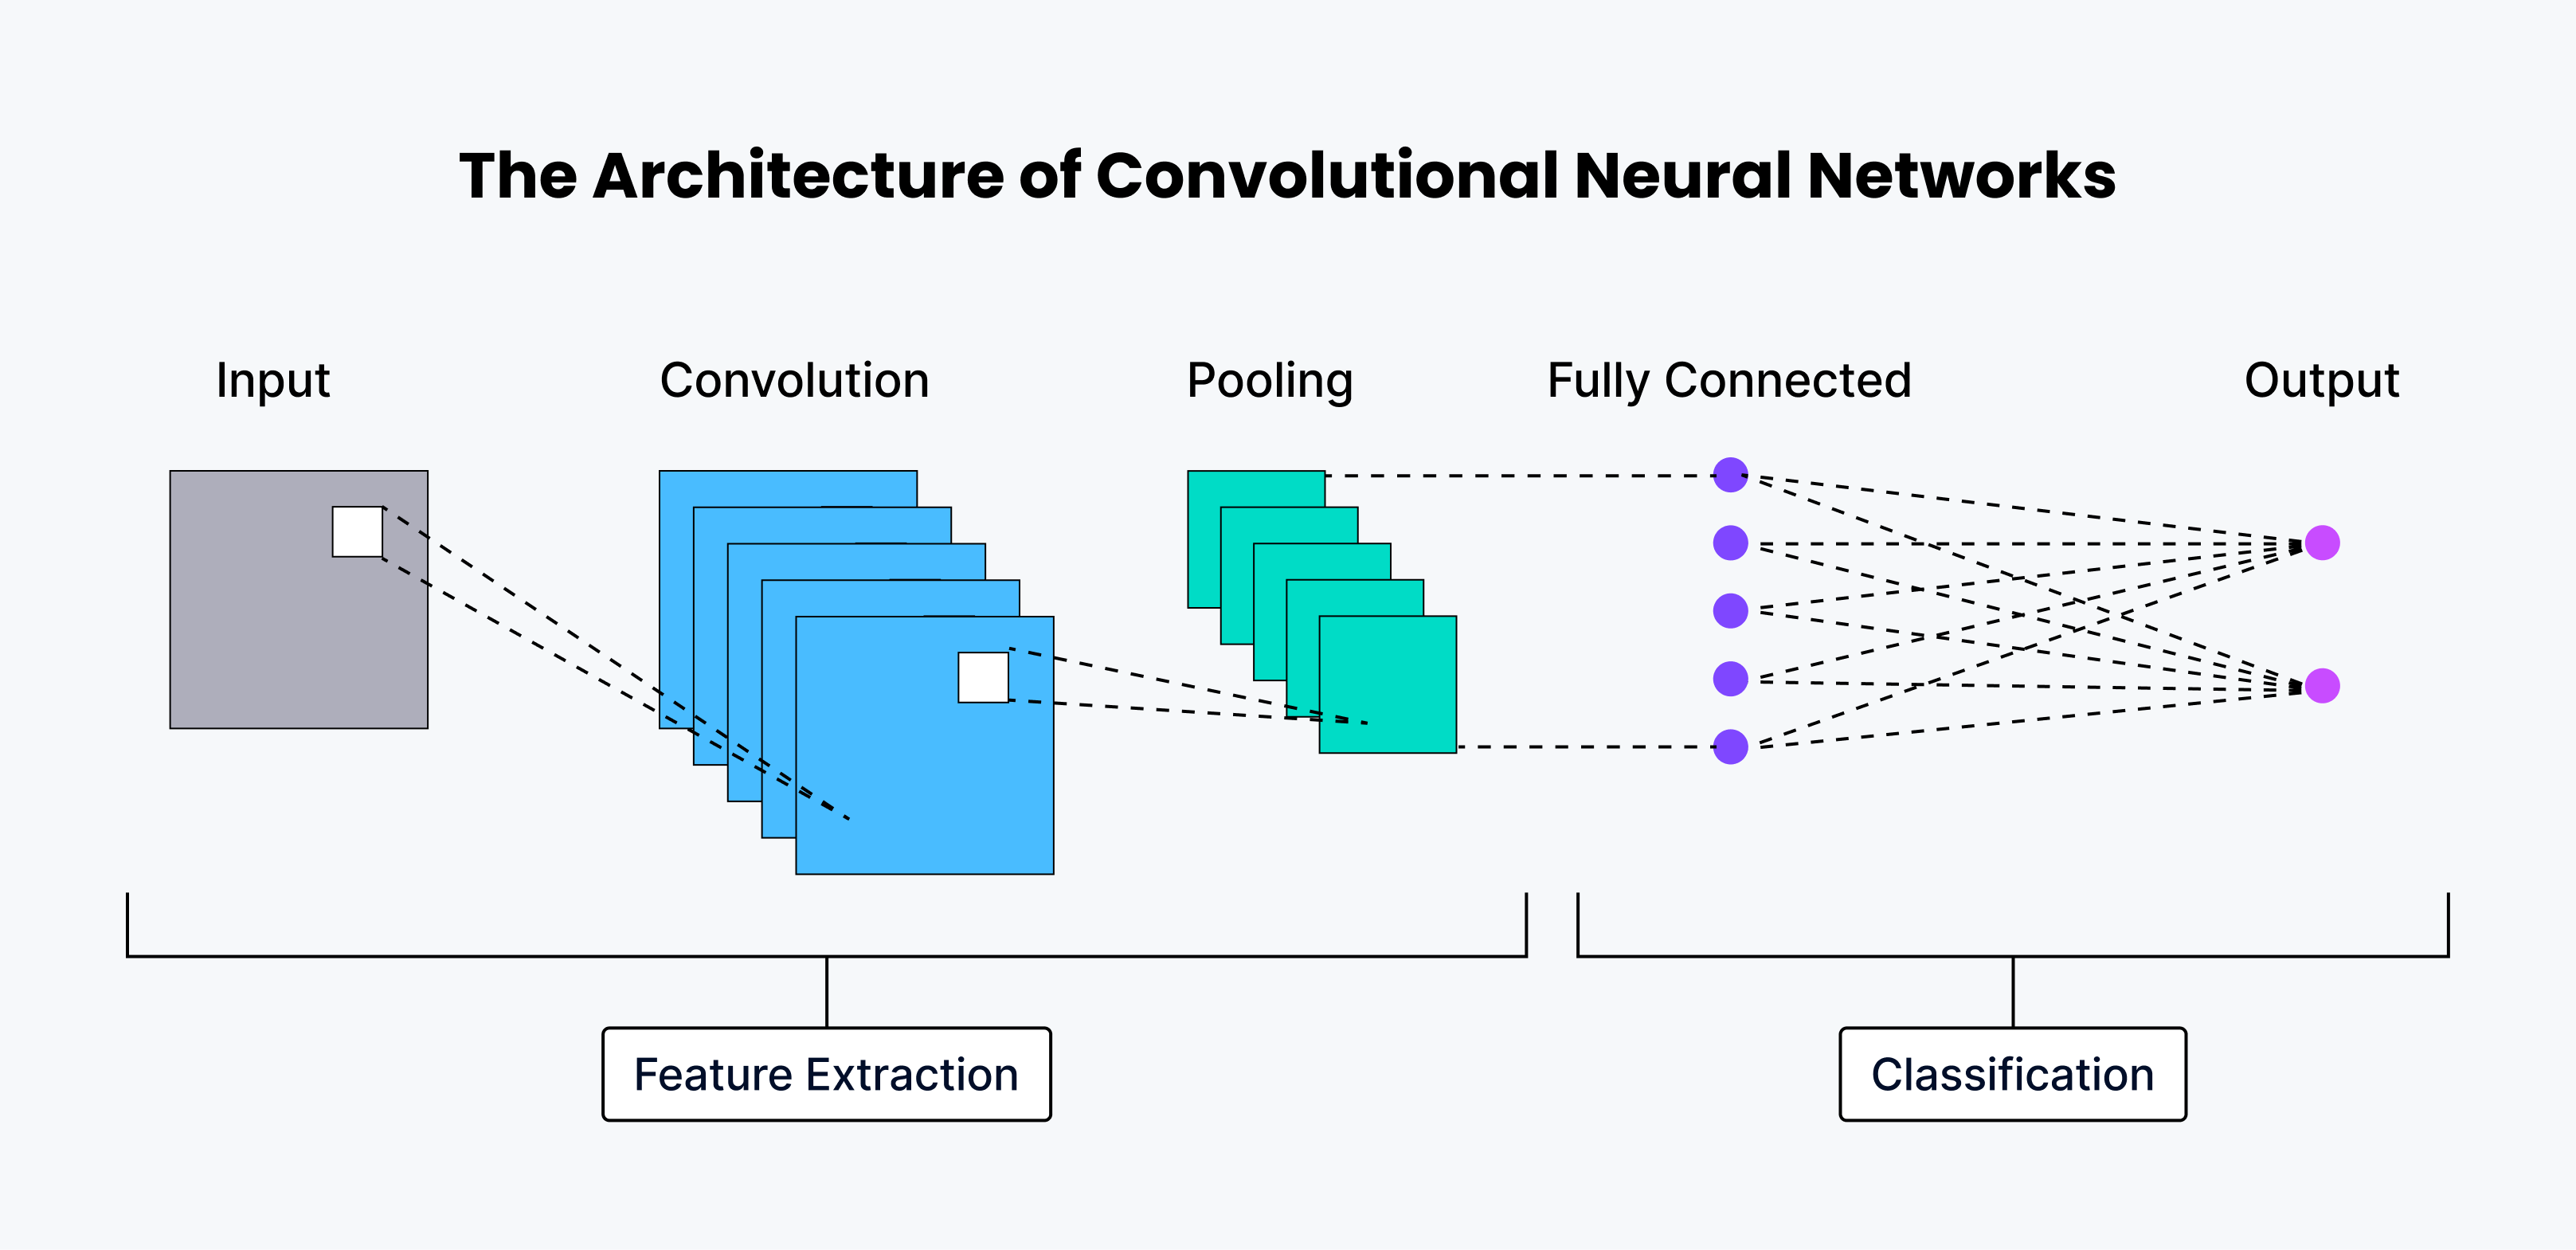

In [21]:
display(Image('CNN-architecture-Zilliz.png'))

## 3. Convolutions

Convolutions are a particular type of mathematics operation performed on two functions $f$ and $g$ (from some set to another set), to produce a third function $f*g$ (with possibly different domain from $f$ and $g$). 

To understand convolutions, I want to work with a few different classes of functions to see how convolutions work in each case:
- Functions from a finite set of time steps to $\mathbb{R}$; these are time series (example stock prices).
- Functions from $\mathbb{R}$ to $\mathbb{R}$.
- Functions of the form $f: \{ \textup{ Pixel grid } \} \to [0,1]$; these are (grayscale) images, where the output represents pixel intesity (normalized to lie in $[0,1]$)!

Note that in each of the above cases, there is a natural arrangement or ordering of the points in the domain which allows us to ask questions about how the function behaves "near" a point. To answer these questions, we often resort to convolutions.

### Using dot products to get behavior near a point
The basic idea is as follows.
- Start with the vector or function $f$ that you want to understand, and the point $t$ in the domain where you want to understand some local behavior.
- Consider a small window of points around $t$, and choose values for all points in this window. Here, small is meant relative to the domain of $f$.
- Extend your selection of values into a vector or function $g$ of the same shape as $f$ by setting all other values to $0$.
- Take the dot product of $f$ and $g$ (which we here denote by $\langle f, g \rangle$) to get a single number that represents the local behavior of $f$ near $t$. The meaning of "dot product" depends on the type of function $f$ and $g$:
    - For time series (i.e. sequences of real numbers that are eventually $0$), the dot product is the sum of the products of the corresponding values of $f$ and $g$:
    \begin{equation*}
        \langle f , g \rangle = \sum_{i = 1}^{\infty} f_i g_i.
    \end{equation*}
    - For functions from $\mathbb{R}$ to $\mathbb{R}$, the dot product is the integral of the product of the two functions:
    \begin{equation*}
        \langle f , g \rangle = \int_{-\infty}^{\infty} f(x) g(x) \, dx.
    \end{equation*}
    - For functions defined on a pixel grid, the dot product is again the sum of the products over the pixels:
    \begin{equation*}
        \langle f , g \rangle = \sum_{\textup{pixels}} f_{\textup{pixel}} g_{\textup{pixel}}.
    \end{equation*}


### Convolutions as a family of dot products
The above situation does not yet describe a convolution, because it only gives us the behavior of $f$ near a single point $t$ in the form of a scalar. Note that the window of values chosen by us is located near $t$ (often-times, it is centered at $t$), and $g$ is zero outside this window. 

The idea now is that we can repeat the above process for every point $t$ in the domain by sliding the window along the domain so that it is centered at $t$. 
For example:
- In the time series case, we can slide the window by $x$, which amounts to replacing $g(t)$ by $g(t - x)$. Thus, the dot product at $t$ (which is the output of the convolution at $t$) is:
\begin{equation*}
    (f * g)(t) = \sum_{i = 1}^{\infty} f_i g_{t-i}.
\end{equation*}

- In the case of functions from $\mathbb{R}$ to $\mathbb{R}$, we can slide the window by $x$, which amounts to replacing $g(t)$ by $g(t - x)$. Thus, the dot product at $t$ (which is the output of the convolution at $t$) is:
\begin{equation*}
    (f * g)(t) = \int_{-\infty}^{\infty} f(x) g(t - x) \, dx.
\end{equation*}
- In the case of functions defined on a pixel grid, sliding the window by a vector $\mathbf{v} = (x,y)$ amounts to replacing $g(\mathbf{t})$ by $g_{\mathbf{t}- \mathbf{v}}$ (NOTE: here, $\mathbf{t}$ is a 2d-vector representing the pixel position in the array, so the formula makes sense). The dot product in this case is a sum over the pixels:
\begin{equation*}
    (f * g)(\mathbf{t}) = \sum_{\mathbf{t} \in \{\textup{pixels}\}} f(\mathbf{v}) g(\mathbf{t} - \mathbf{v}).
\end{equation*}

#### Example 1: Moving averages of stock prices

We can visualize the NVDA stock as a **time series**, which basically an ordered list of real numbers indexed by date. Equivalently, you can think of the stock data as a function from the "dateline" to $\mathbb{R}$. 

Here is a visualization of the stock price from 2014 to 2024.

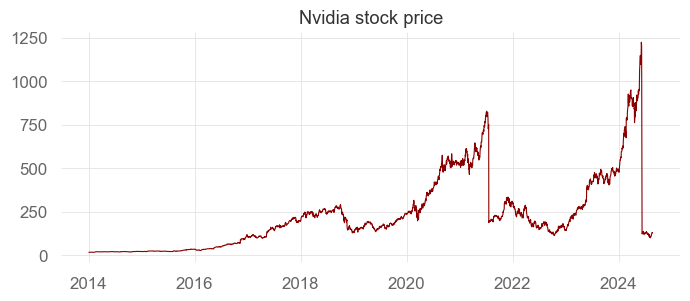

In [22]:
import pandas as pd
nvda_stock = pd.read_csv('NVDA_stock.csv')
# use the date as the index
nvda_stock['date'] = pd.to_datetime(nvda_stock['date'])
nvda_stock.set_index('date', inplace=True)
# plot close price of NVDA as a time series
plt.figure(figsize=(8, 3))
plt.plot(nvda_stock['close'], c='darkred', linewidth=0.8)
plt.title('Nvidia stock price')
plt.grid(True)
plt.show()

Suppose we want to get rid of the small variations in the stock price and only keep the long-term trends. One way to replace each stock price by its average over the past $n$ days. That is, we seek a new function $f_n(t)$ whose value at $t$ equals the average stock price over the interval $[t-n, t]$.

We can accomplish this by applying the **$n$-day moving average** filter:
\begin{equation*}
    g_n(x) = \begin{cases}
        \frac{1}{n} & \text{if } 0 \leq x < n, \\
        0 & \text{otherwise}.
    \end{cases}
\end{equation*}
That is, $g_n$ is a function that is $1/n$ on the interval $[0, n)$ and $0$ elsewhere. It follows that for any $t$, the translated function $g_n(t-x)$ is $1/n$ on the interval $[t-n, t]$ and $0$ elsewhere. Thus, for any $t$ and any date $i$, we have:
\begin{equation*}
    f(i)g_n(t-i) = \begin{cases}
        \frac{f(i)}{n} & \text{if } t-n \leq i \leq t, \\
        0 & \text{otherwise}.
    \end{cases}
\end{equation*}
Summing over all $i$ gives the $n$-day moving average of the stock price at date $t$, which is the output of the convolution at $t$:
\begin{align*}
    (f * g_n)(t) & = \sum_{i = 0}^{n-1} f(i)g_n(t-i) \\
    & = \frac{f(t) + f(t-1) + \dotsb + f(t-n+1)}{n}.
\end{align*}

Let's illustrate this by taking moving averages of NVDA in the years 2022 and 2023. You will notice that longer time windows smooth out the stock price more.

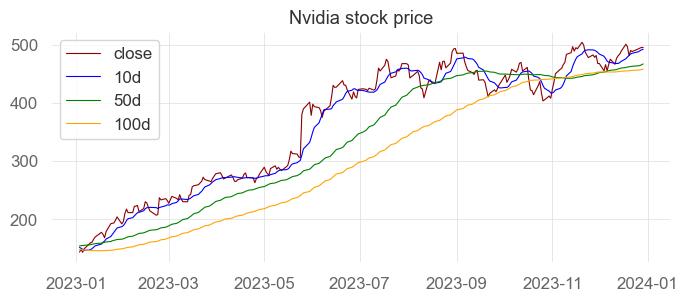

In [23]:
# Compute 10-day moving average and 50-day moving average
nvda_stock['10d'] = nvda_stock['close'].rolling(10).mean()
nvda_stock['50d'] = nvda_stock['close'].rolling(50).mean()
nvda_stock['100d'] = nvda_stock['close'].rolling(100).mean()

# plot close, 10d, 50d, and 100d moving averages for the year 2023
plt.figure(figsize=(8, 3))
plt.plot(nvda_stock['close']['2023'], c='darkred', linewidth=0.8, label='close')
plt.plot(nvda_stock['10d']['2023'], c='blue', linewidth=0.8, label='10d')
plt.plot(nvda_stock['50d']['2023'], c='green', linewidth=0.8, label='50d')
plt.plot(nvda_stock['100d']['2023'], c='orange', linewidth=0.8, label='100d')
plt.title('Nvidia stock price')
plt.legend()
plt.grid(True)
plt.show()

#### Example 2: Differencing time series
Another very natural thing we might wish to do is to compute the change in stock price from one day to the next. This is called **differencing** the time series. To accomplish this, we apply the **difference filter**:
\begin{equation*}
    g(x) = \begin{cases}
        1 & \text{if } x = 0, \\
        -1 & \text{if } x = 1, \\
        0 & \text{otherwise}.
    \end{cases}
\end{equation*}
It follows that for any $t$ and date $i$, we have:
\begin{equation*}
    f(i)g(t-i) = \begin{cases}
        f(t) & \text{if } i = t, \\
        -f(t-1) & \text{if } i = t-1, \\
        0 & \text{otherwise}.
    \end{cases}
\end{equation*}
Summing over all $i$ gives the difference in stock price at date $t$, which is the output of the convolution at $t:
\begin{align*}
    (f * g)(t) & = \sum_{i = 0}^{1} f(i)g(t-i) \\
    & = f(t) - f(t-1).
\end{align*}

Let's illustrate this by differencing the stock price of NVDA in the year 2023. You will notice that the differenced stock price is much more volatile than the original stock price; the moral of the story is that even if there is a clear overall increasing trend, the stock price (hence, the returns) can still fluctuate wildly from day to day!

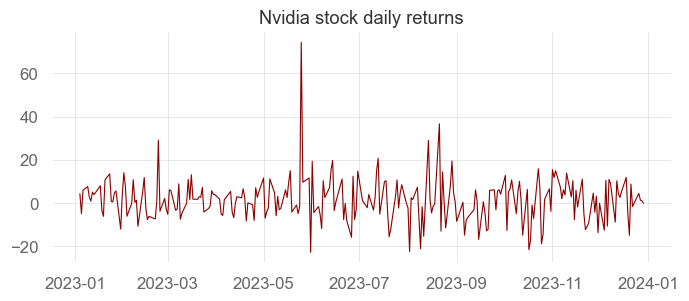

In [27]:
#plot the daily returns
plt.figure(figsize=(8, 3))
plt.plot(nvda_stock['close']['2023'] - nvda_stock['close']['2023'].shift(1), c='darkred', linewidth=0.8)
plt.title('Nvidia stock daily returns')
plt.grid(True)
plt.show()

#### Example 3: Convolution with a dirac delta
Suppose $f : \mathbb{R} \to \mathbb{R}$ is an integrable function with anti-derivative $F$. For every $\epsilon > 0$, consider the function $g_{\epsilon}$ defined by:
\begin{equation*}
    g_{\epsilon}(x) = \begin{cases}
        \frac{1}{2\epsilon} & \text{if } -\epsilon \leq x \leq \epsilon, \\
        0 & \text{otherwise}.
    \end{cases}
\end{equation*}
Note that $g_{\epsilon}$ can be thought of as the probability density function of a random variable that is uniformly distributed on the interval $[-\epsilon, \epsilon]$, since
\begin{equation*}
    \int_{-\infty}^{\infty} g_{\epsilon}(x) \, dx = \frac{1}{2\epsilon} \int_{-\epsilon}^{\epsilon} \, dx = 1.
\end{equation*}
More generally, for any $t$, the translated function $g_{\epsilon}(t-x)$ is $1/(2\epsilon)$ on the interval $[t-\epsilon, t+\epsilon]$ and $0$ elsewhere, so that
\begin{equation*}
    \int_{-\infty}^{\infty} g_{\epsilon}(t-x) \, dx = \frac{1}{2\epsilon} \int_{t-\epsilon}^{t+\epsilon} \, dx = 1.
\end{equation*}
The convolution of $f$ with $g_{\epsilon}$ is then:
\begin{align*}
    (f * g_{\epsilon})(t) & = \int_{-\infty}^{\infty} f(x)g_{\epsilon}(t-x) \, dx \\
    & = \frac{1}{2\epsilon} \int_{t-\epsilon}^{t+\epsilon} f(x) \, dx \\
    & = \frac{ F(t+\epsilon) - F(t-\epsilon) }{2\epsilon}.
\end{align*}
This is a difference quotient! As $\epsilon \to 0$, the difference quotient converges to the derivative of $F$ at $t$. By the Fundamental Theorem of Calculus, this is $f(t)$, i.e.
\begin{equation*}
    \lim_{\epsilon \to 0} (f * g_{\epsilon})(t) = \lim_{\epsilon \to 0} \frac{ F(t+\epsilon) - F(t-\epsilon) }{2\epsilon} = f(t).
\end{equation*}
The **Dirac Delta function** $\delta$ is borne out of the desire to pass the limit to the function $g_{\epsilon}$ insides the convolution, so that one could then write
\begin{equation*}
    f(t) = (f * \delta)(t) = \int_{-\infty}^{\infty} f(x) \delta(t-x) \, dx.
\end{equation*}
Unfortunately, this doesn't directly work, simply by noting that as $\epsilon \to 0$, the limit of $g_{\epsilon}$ would look like:
\begin{equation*}
    \lim_{\epsilon \to 0} g_{\epsilon}(x) = \begin{cases}
        \infty & \text{if } x = 0, \\
        0 & \text{otherwise}.
    \end{cases}
\end{equation*}
Well, a lot of folks are okay with this definition (plus the additional assumption that the integral over the whole real line is $1$), but it's clearly not a function. There are two ways to resolve this:
- View it as a "distribution" and not a function.
- Drop the function altogether and define a suitable *Dirac measure* on the real line, which assigns a measure of $1$ to any set containing $0$, and $0$ otherwise. 

**Remark**: The Dirac Delta is famous because of its role in physics. However, it also serves a fundamental purpose from a more abstract perspective. Namely, there are several natural spaces of functions that are closed under the convolution operation. In fact, convolution behaves just like multiplication on these spaces (associative, distributive, commutative, etc.) There's just one problem... these spaces may not have an identity element for this "multiplication" operation! Thus, the The Dirac Delta serves as the identity element for the convolution operation on these spaces (even if it's not actually a function, lol).

#### Example 4: Convolution of probability distributions
I won't say much about this, simply mention that if $X$ and $Y$ are two random variables with probability density functions $f$ and $g$, then the probability density function of $X + Y$ is the convolution of $f$ and $g$:
\begin{equation*}
    f_{X+Y}(x) = (f * g)(x) = \int_{-\infty}^{\infty} f(x-y)g(y) \, dy.
\end{equation*}
This is a fundamental result in probability theory. 

Watch the following masterpiece of a video by 3Blue1Brown for an incredibly clear explanation: https://www.youtube.com/watch?v=IaSGqQa5O-M

#### Example 5: Edge detection in images
